In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import bambi as bmb
import seaborn as sns


# Chapter 18 examples

## 18.1 ,  Logistic

In [2]:
climbers = pd.read_csv("climbers.csv")
climbers.head()

,expedition_id,member_id,success,year,season,age,expedition_role,oxygen_used
0,AMAD81101,AMAD81101-03,True,1981,Spring,28,Climber,False
1,AMAD81101,AMAD81101-04,True,1981,Spring,27,Exp Doctor,False
2,AMAD81101,AMAD81101-02,True,1981,Spring,35,Deputy Leader,False
3,AMAD81101,AMAD81101-05,True,1981,Spring,37,Climber,False
4,AMAD81101,AMAD81101-06,True,1981,Spring,43,Climber,False


In [3]:

total = climbers.shape[0]
climbers[['success','member_id']].groupby('success').count().assign(percent = lambda x: x.member_id/total).rename(columns = {'member_id':'count'})

,count,percent
success,,
False,1269,0.611272
True,807,0.388728


In [8]:
climbers['expedition_id'].unique().shape[0] # how many expeditions?

200

<AxesSubplot:ylabel='Count'>

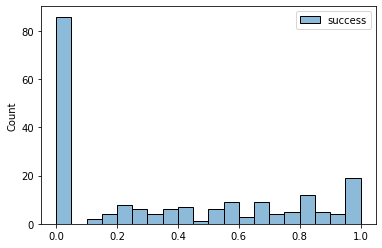

In [11]:
expedition_success = climbers[['expedition_id', 'success']].groupby('expedition_id').mean()
sns.histplot(data = expedition_success, binwidth=.05)

### Success by age and oxygen use

In [16]:
data_by_age_oxygen = climbers.groupby(['age','oxygen_used']).mean().reset_index().drop(columns='year')

<AxesSubplot:xlabel='age', ylabel='success'>

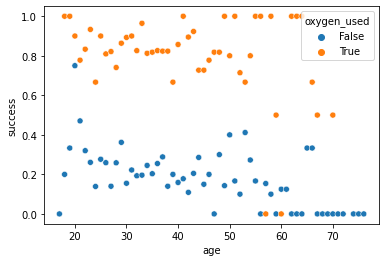

In [17]:
sns.scatterplot(data = data_by_age_oxygen, x= 'age', y='success', hue = 'oxygen_used')

Binomial model

In [4]:
model1 = bmb.Model('success ~ age + oxygen_used + (1|expedition_id)',data = climbers, family="bernoulli")
model1.build()
model1

Formula: success ~ age + oxygen_used + (1|expedition_id)
Family name: Bernoulli
Link: logit
Observations: 2076
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 9.3311)
    age ~ Normal(mu: 0.0, sigma: 0.2394)
    oxygen_used ~ Normal(mu: 0.0, sigma: 5.5123)

  Group-level effects
    1|expedition_id ~ Normal(mu: 0, sigma: HalfNormal(sigma: 9.3311))

In [5]:
results = model1.fit()

Modeling the probability that success==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, age, oxygen_used, 1|expedition_id_sigma, 1|expedition_id_offset]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 80 seconds.


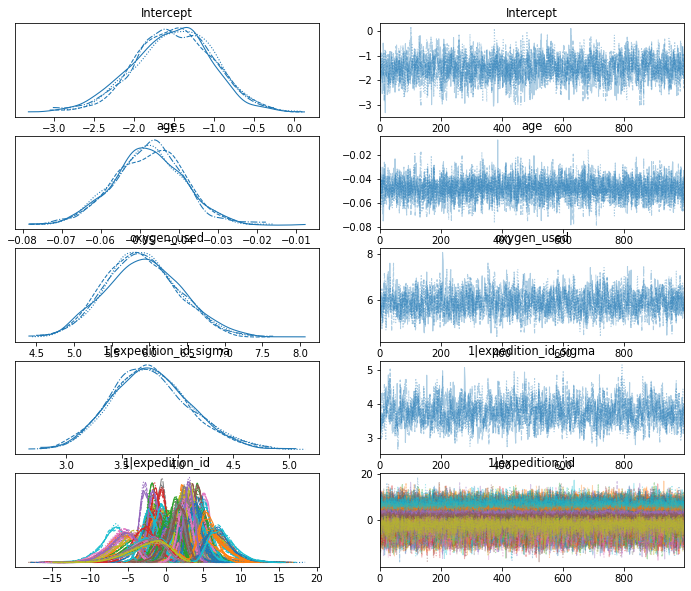

In [21]:
az.plot_trace(results,compact=True);

In [6]:
model1.predict(results,kind='pps')
post_pred = results.posterior_predictive.to_dataframe().reset_index()
post_df = results.posterior.to_dataframe().reset_index()

Each draw contains a prediction now for each of the climbers.  We can use this to manually check that the results make sense

<AxesSubplot:>

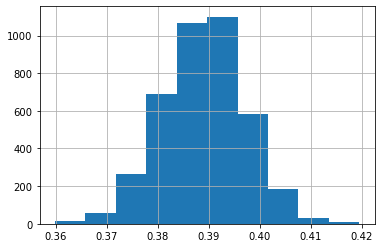

In [23]:
post_pred.groupby(['chain','draw']).mean()['success'].hist()

This is centered on the oberved success rate.
Now to look at the posterior values:


In [25]:
az.summary(results, hdi_prob=0.8).head(4)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.503,0.491,-2.087,-0.844,0.015,0.011,1078.0,1571.0,1.01
age,-0.048,0.009,-0.059,-0.037,0.000,0.000,4356.0,3119.0,1.00
oxygen_used,5.911,0.493,5.223,6.492,0.013,0.009,1515.0,2006.0,1.00
1|expedition_id_sigma,3.765,0.356,3.295,4.202,0.012,0.008,935.0,1915.0,1.00


As text says, age coeffienct is signficant, as is oxygen used. . , improves odds by a factor 360 (mean)

In [26]:
np.exp(5.91)

368.706155409357

### Regression lines 

Now i want to plot plausible (median) regression lines, using draws for intercept and slope. Here we want to just plot the medians.

Generate 100 samples:

In [7]:
lines = post_df.query('expedition_id__factor_dim =="AMAD03107"')[['Intercept','age','oxygen_used']].sample(50,axis=0).reset_index(drop=True)
lines.head()

,Intercept,age,oxygen_used
0,-1.491340,-0.049832,6.070672
1,-1.738791,-0.034416,5.612368
2,-1.136449,-0.047766,6.151102
3,-1.361544,-0.060548,5.904258
4,-2.037850,-0.042303,6.181930


In [8]:
data_to_plot = pd.DataFrame()
# is this defined somewhere?
def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))

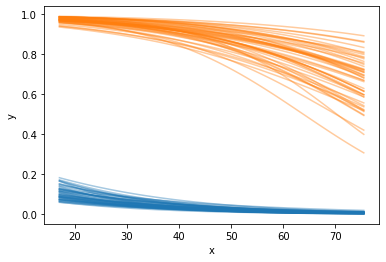

In [9]:
fig, ax = plt.subplots()
data_to_plot['x'] =np.tile(np.arange(climbers['age'].min(), climbers['age'].max(),.5),2)
nrows = len(data_to_plot)
data_to_plot['oxygen_used'] = np.concatenate([np.repeat(1,nrows/2 ),np.repeat(0,nrows/2)])

for (i,row) in lines.iterrows():
    data_to_plot['y_logit'] = row.Intercept + row.age * data_to_plot.x + row.oxygen_used*data_to_plot.oxygen_used
    data_to_plot['y'] = inv_logit(data_to_plot['y_logit'])
    sns.lineplot(data= data_to_plot, x = 'x', y= 'y', hue='oxygen_used', ax= ax, legend=False, alpha  =0.4)


Minor side track checking out posterior mean, can we use it to make that plot? Yes, and it looks more like the one in the book, which is interesting

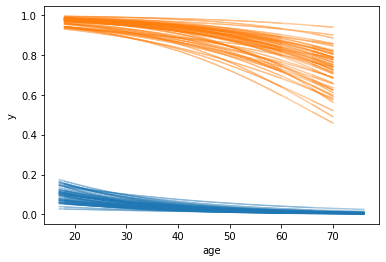

In [131]:
model1.predict(results,kind='mean',include_group_specific = False)
succ_df = results.posterior.success_mean.to_dataframe().reset_index()
# Multiindex is a pita so we will create a new one. I wonder if there is a better way to do this???
succ_df['draw_num'] = succ_df['draw'] + succ_df['chain']*(succ_df['draw'].max()+1)
# grab a few sample row draw numbers.
sample_draw_num = succ_df['draw_num'].sample(50)
 
fig, ax = plt.subplots()
for x in sample_draw_num:
    climbers['y']= succ_df[succ_df['draw_num']==x]['success_mean'].values
    sns.lineplot(data= climbers, x = 'age', y= 'y', hue='oxygen_used', ax= ax, legend=False, alpha  =0.4)

### Posterior classification

Grab a signle expedition (as before) to  get all group level (not specific) effects. 

In [135]:
post_group_level = post_df.query("expedition_id__factor_dim == 'AMAD03107'").reset_index()[['Intercept','age','oxygen_used','1|expedition_id_sigma']]
post_group_level.head()

,Intercept,age,oxygen_used,1|expedition_id_sigma
0,-1.531291,-0.044740,5.438662,3.223464
1,-1.565782,-0.048206,6.218861,3.423495
2,-0.963866,-0.058951,5.568346,3.276811
3,-1.240741,-0.052946,5.921941,3.613661
4,-0.976204,-0.061174,5.402416,3.841538


Suppose four climbers set out on a new expedition. Two are 20 years old and two are 60 years old. Among both age pairs, one climber plans to use oxygen and the other does not.



In [194]:
four_climbers = pd.DataFrame({ 'age':[20,20,60,60], 'oxygen_used':[1,0,1,0]})

In [153]:
four_climbers_median = model1.predict(results, kind = "mean",data = four_climbers, include_group_specific=False, inplace = False)

In [192]:
four_climbers_median.posterior.success_mean.to_dataframe().groupby('success_obs').mean()

,success_mean
success_obs,
0,0.965714
1,0.085317
2,0.811956
3,0.013959


Ok but this doesnt include the random group specific effects. They dont average away because we will be averaging probabilities which is a nonlinear functinon of the log-odds. So we use the posterior draws directly to get that:

In [211]:
# use 100 draws

include_group_specific = True

post_draws = post_group_level.sample(500)
for (i,row) in four_climbers.iterrows():
    logit = post_draws['Intercept'] + row['age']*post_draws['age'] + post_draws['oxygen_used']*row['oxygen_used'] 
    if include_group_specific:
        group_spec = np.random.normal(scale = post_draws['1|expedition_id_sigma'])
        logit = logit + group_spec
    prob = inv_logit(logit)
    four_climbers.loc[i,'mean_prob'] = prob.mean()
    four_climbers.loc[i,'mean_log_odds']=logit.mean()

four_climbers['prob_from_mean_log_odds'] = inv_logit(four_climbers['mean_log_odds'])
four_climbers

,age,oxygen_used,mean_prob,mean_log_odds,prob_from_mean_log_odds
0,20,1,0.797257,3.471698,0.969872
1,20,0,0.296794,-2.308944,0.090385
2,60,1,0.649663,1.523281,0.821021
3,60,0,0.146652,-4.438722,0.011673


Note that if I use the mean_log_odds to compute the probabilies i will get the same probabilites that i would get without group level effects, as can be seen by putting 'include_group_specific' = False in the sim.  WHat we really want is the `mean_prob` because this is what you get if you use the computed probability for each draw to compute a success/fail and then average those. 

### Model Evaluation

Lets add the predicted probabilty for each climber (including the group specific effect now)

In [240]:
model1.predict(results,kind='mean',include_group_specific = True)
success_p = results.posterior.success_mean.to_dataframe().groupby('success_obs').mean()
climbers['pred_prob'] =  success_p['success_mean']
climbers['prediction'] = (climbers.pred_prob > 0.5) 
accuracy = (climbers['prediction'] == climbers['success']).mean()
print(f"Overall Accuracy is {accuracy}\n")
pd.crosstab(climbers['success'],climbers['prediction'], normalize = 'index')
 


Overall Accuracy is 0.9171483622350675



prediction,False,True
success,,
False,0.925138,0.074862
True,0.095415,0.904585


In [239]:
pd.crosstab(climbers['success'],climbers['prediction'])

prediction,False,True
success,,
False,1174,95
True,77,730


## 18.2 Poission / Neg Binomial

In [241]:
airbnb = pd.read_csv("airbnb.csv")
airbnb.head()

,price,rating,reviews,room_type,accommodates,bedrooms,minimum_stay,neighborhood,district,walk_score,transit_score,bike_score
0,85,5.0,6,Private room,2,1,1.0,Albany Park,Far North,87,62,68
1,35,5.0,8,Private room,1,1,1.0,Albany Park,Far North,87,62,68
2,175,4.5,7,Entire home/apt,4,2,2.0,Albany Park,Far North,87,62,68
3,75,5.0,52,Private room,2,1,1.0,Albany Park,Far North,87,62,68
4,160,5.0,3,Entire home/apt,6,2,1.0,Albany Park,Far North,87,62,68


In [244]:
len(airbnb.neighborhood.unique())

43

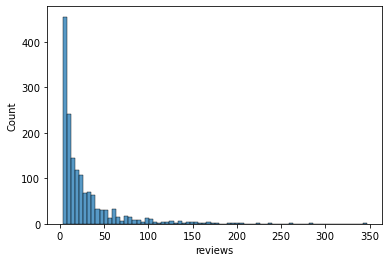

In [260]:
sns.histplot(airbnb, x = 'reviews');

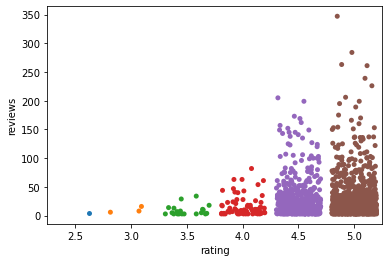

In [259]:
sns.stripplot(data = airbnb, x = 'rating', y ='reviews', jitter = 0.4);

In [271]:
air_bnb_by_rating['reviews']

rating
2.5     4.000000
3.0    10.000000
3.5     8.952381
4.0    16.123288
4.5    28.716505
5.0    27.700422
Name: reviews, dtype: float64

<AxesSubplot:xlabel='rating', ylabel='reviews'>

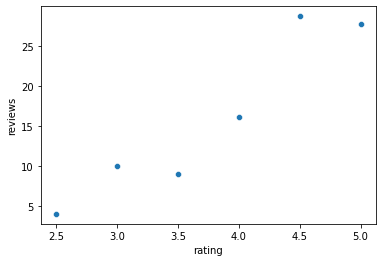

In [272]:
air_bnb_by_rating = airbnb.groupby('rating').mean()
sns.scatterplot(data = air_bnb_by_rating, x = 'rating', y= 'reviews');

In [273]:
20/2.5

8.0

<AxesSubplot:xlabel='room_type', ylabel='reviews'>

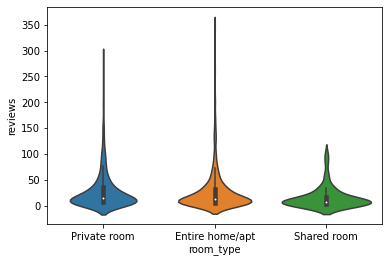

In [261]:
sns.violinplot(data = airbnb, x= 'room_type', y='reviews')

Now to try and model the thing

In [265]:
airbnb_model_1 = bmb.Model("reviews ~ rating + room_type + (1|neighborhood)", data = airbnb, family = "poisson")
airbnb_model_1.build()
airbnb_model_1

Formula: reviews ~ rating + room_type + (1|neighborhood)
Family name: Poisson
Link: log
Observations: 1561
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 35.2916)
    rating ~ Normal(mu: 0.0, sigma: 7.3763)
    room_type ~ Normal(mu: [0. 0.], sigma: [ 5.0379 14.198 ])

  Group-level effects
    1|neighborhood ~ Normal(mu: 0, sigma: HalfNormal(sigma: 35.2916))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, rating, room_type, 1|neighborhood_sigma, 1|neighborhood_offset]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 130 seconds.
The acceptance probability does not match the target. It is 0.7133, but should be close to 0.8. Try to increase the number of tuning steps.


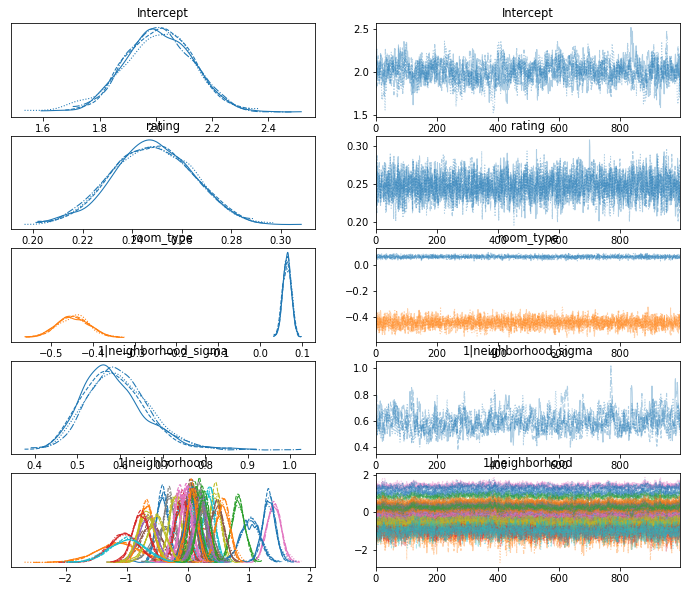

In [281]:
results1 = airbnb_model_1.fit()
az.plot_trace(results1);

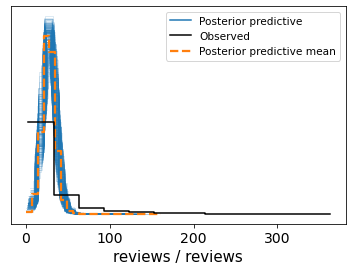

In [316]:
airbnb_model_1.predict(results1, kind = 'pps')
az.plot_ppc(results1, num_pp_samples= 200);

The result is not nearly as nice as the kdi generated by pp_check in r, but point is made, Poisson does not do so well. 

In [283]:
airbnb_model_2 = bmb.Model("reviews ~ rating + room_type + (1|neighborhood)", data = airbnb, family = "negativebinomial")
airbnb_model_2.build()
airbnb_model_2

Formula: reviews ~ rating + room_type + (1|neighborhood)
Family name: Negativebinomial
Link: log
Observations: 1561
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 0, sigma: 35.2916)
    rating ~ Normal(mu: 0.0, sigma: 7.3763)
    room_type ~ Normal(mu: [0. 0.], sigma: [ 5.0379 14.198 ])

  Group-level effects
    1|neighborhood ~ Normal(mu: 0, sigma: HalfNormal(sigma: 35.2916))

  Auxiliary parameters
    alpha ~ HalfCauchy(beta: 1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, rating, room_type, 1|neighborhood_sigma, 1|neighborhood_offset, reviews_alpha]


/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/ronaldlegere/opt/anaconda3/envs/BayesRules/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 72 seconds.


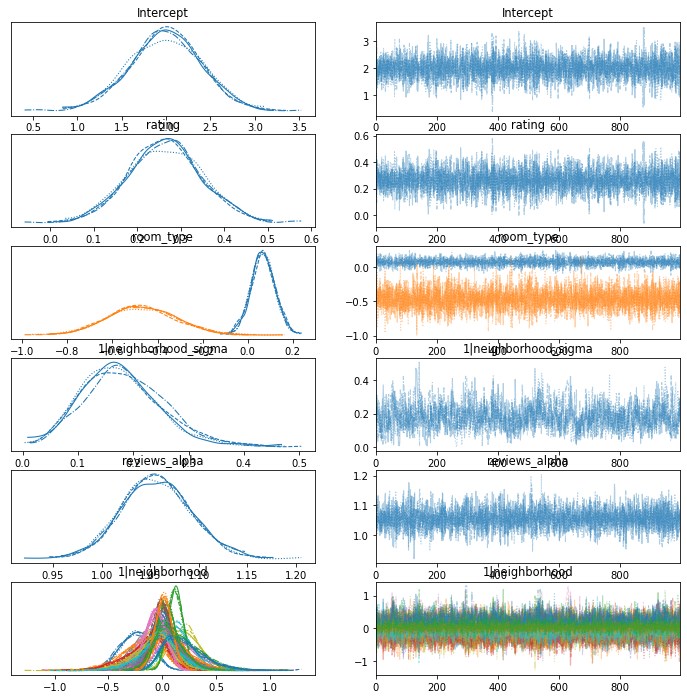

In [284]:
results2 = airbnb_model_2.fit()
az.plot_trace(results2);

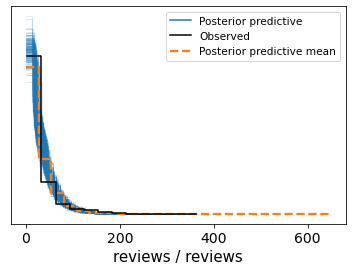

In [295]:
airbnb_model_2.predict(results2, kind = 'pps')
az.plot_ppc(results2, num_pp_samples= 200);

Really should investigate the priors more, but in the interest of time we wil press on. But if there were a real example we would spend some time looking at the prior predictive plots. 

In [288]:
az.summary(results2, hdi_prob=.8).head(10)

,mean,sd,hdi_10%,hdi_90%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,1.994,0.408,1.451,2.484,0.006,0.004,5490.0,2647.0,1.00
rating,0.265,0.085,0.150,0.369,0.001,0.001,5490.0,2668.0,1.00
room_type[Private room],0.068,0.053,0.002,0.136,0.001,0.001,5616.0,2508.0,1.00
room_type[Shared room],-0.469,0.151,-0.664,-0.279,0.002,0.001,6049.0,3066.0,1.00
1|neighborhood_sigma,0.179,0.072,0.084,0.263,0.003,0.002,713.0,1094.0,1.01
reviews_alpha,1.056,0.035,1.015,1.105,0.000,0.000,5186.0,2649.0,1.00
1|neighborhood[Albany Park],-0.245,0.146,-0.410,-0.034,0.004,0.003,1630.0,2181.0,1.00
1|neighborhood[Archer Heights],0.019,0.170,-0.188,0.213,0.002,0.003,5478.0,2400.0,1.00
1|neighborhood[Avondale],0.005,0.106,-0.130,0.134,0.002,0.002,4730.0,2775.0,1.00
1|neighborhood[Beverly],0.013,0.179,-0.203,0.238,0.002,0.003,5588.0,2478.0,1.00


First we note a significant positive effect of rating on number of reviews. Each rating point results in a  between (exp(0.15), exp(0.47)) factor increase (1.17 to 1.45).  

Second recalling that the 'entire house' case is the base case., we see a significant decrease for the shared room number of ratings.  We can also see that the range of neighborood base interecepts varies quite a bit!

Looking at The Loop, East Garfield Park and Albany park posterior pred for private 5 star reviews:

In [289]:
airbnb

,price,rating,reviews,room_type,accommodates,bedrooms,minimum_stay,neighborhood,district,walk_score,transit_score,bike_score
0,85,5.0,6,Private room,2,1,1.0,Albany Park,Far North,87,62,68
1,35,5.0,8,Private room,1,1,1.0,Albany Park,Far North,87,62,68
2,175,4.5,7,Entire home/apt,4,2,2.0,Albany Park,Far North,87,62,68
3,75,5.0,52,Private room,2,1,1.0,Albany Park,Far North,87,62,68
4,160,5.0,3,Entire home/apt,6,2,1.0,Albany Park,Far North,87,62,68
...,...,...,...,...,...,...,...,...,...,...,...,...
1556,85,5.0,4,Private room,3,1,3.0,Woodlawn,South,69,73,72
1557,100,5.0,5,Entire home/apt,4,2,1.0,Woodlawn,South,69,73,72
1558,55,4.0,5,Private room,3,1,3.0,Woodlawn,South,69,73,72
1559,90,4.5,25,Entire home/apt,4,2,2.0,Woodlawn,South,69,73,72


In [293]:
predicted_reviews  = airbnb_model_2.predict(results2, kind = "pps", data = pd.DataFrame({'neighborhood':['Albany Park', 'The Loop', 'East Garfield Park'], 
                                                                                          'rating':np.repeat(5,3), 
                                                                                           'room_type':np.repeat('Entire home/apt',3)}), inplace =False)

[(0.0, 150.0)]

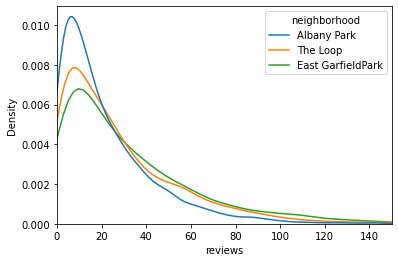

In [314]:
reviews = predicted_reviews.posterior_predictive.to_dataframe().reset_index()
reviews['neighborhood'] = reviews['reviews_dim_0'].apply(lambda x: 'Albany Park' if x ==0 else ('The Loop' if x == 1 else 'East GarfieldPark') )
plot = sns.kdeplot(data = reviews , x='reviews' , hue= 'neighborhood')
plot.set(xlim=(0,150))

Ok last thing we want to do is look at the accuracy (within test data) using our posterior predictive. 

In [319]:
airbnb_model_2.predict(results2, kind = 'pps') # rerun to make sure we got the right kind of predictions in our idata
results2.posterior_predictive.to_dataframe()

reviews
chain draw reviews_dim_0         
0     0    0                   12
           1                   43
           2                    7
           3                    7
           4                   28
...                           ...
3     999  1556                12
           1557                77
           1558                80
           1559                 6
           1560                10

[6244000 rows x 1 columns]